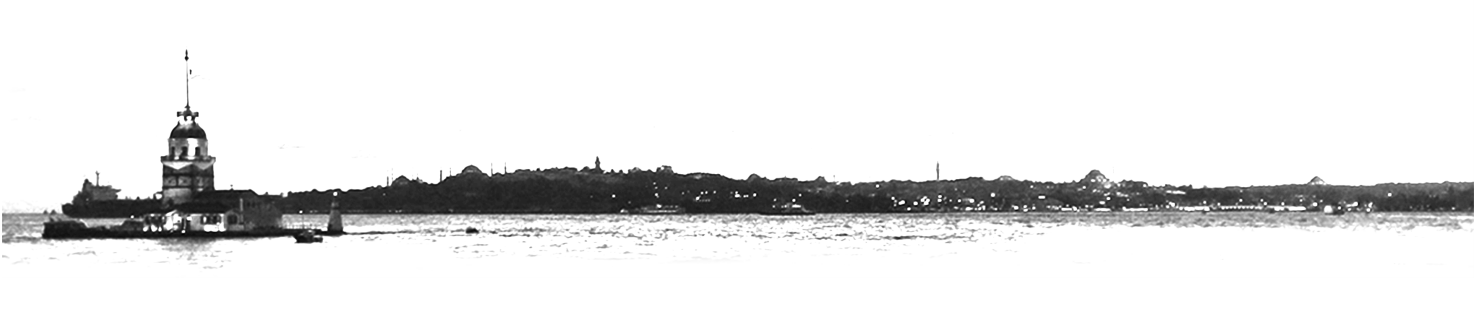


# Capstone Project - The Battle of the Neighborhoods 
Applied Data Science Capstone by IBM/Coursera

### A. Introduction 

#### A.1. A survey on the most popular venues around the main hospitals in Istanbul

Istanbul is the most populous city in Turkey and the country's economic, cultural and historic center with 15 million population and 2.813 people per square kilometer. The city is divided into 39 districts and most of the districts differ from each other with different characteristics [1]. 

According to the last data of TUIK, there are 33.052 doctors, 34.502 nurses, and 27.392 other health care workers currently working in Istanbul [2].

This analysis based on 22 university hospitals in Istanbul aims to be a guide for health care workers who are about to move to Istanbul and need information about the neighbourhood of hospital where they will work in.

#### A.2. Data description

Following data sources will be used to extract and generate the required information:

   - The dataset of health centers in Istanbul will be obtained from Istanbul Metropolitan Municipality [3]
    
   - The number of venues and their type and location in every hospital neighborhood will be obtained using Foursquare API [4]

### B. Data acquisition and cleaning

#### B.1. Data Sources

Let's start with getting the libraries which are needed for the project

In [1]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!pip install geopy
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 
import json 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!pip install folium
import folium

!pip install -U yellowbrick
!pip install -U imbalanced-learn

print('Libraries imported.')

Requirement already up-to-date: yellowbrick in /Users/gonca/opt/anaconda3/lib/python3.8/site-packages (1.2)
Requirement already up-to-date: imbalanced-learn in /Users/gonca/opt/anaconda3/lib/python3.8/site-packages (0.7.0)
Libraries imported.


Let's obtain the dataset of health centers in Istanbul from Istanbul Metropolitan Municipality. To visualize the Turkish alphabet properly, 'windows-1254' encoding will be used.

In [2]:
url='https://data.ibb.gov.tr/dataset/bd3b9489-c7d5-4ff3-897c-8667f57c70bb/resource/f2154883-68e3-41dc-b2be-a6c2eb721c9e/download/salk-kurum-ve-kurulularna-ait-bilgiler.csv'
df=pd.read_csv(url, encoding='windows-1254')
df.head()

,ILCE_UAVT,ILCE_ADI,ADI,ALT_KATEGORI,ADRES,TELEFON,WEBSITESI,ACIL_SERVIS,YATAK,AMBULANS,MAHALLE,ENLEM,BOYLAM
0,1421.0,KADIKÖY,Marmara Veteriner Kliniği,Veteriner,Bahçeler Sk. No:3 FENERYOLU/KADIKÖY,0216 347 49 42,NaN,NaN,0.0,Yok,FENERYOLU,40.979645,29.050702
1,1327.0,FATİH,İstanbul Üniversitesi-Cerrahpaşa Tıp Fakültesi...,Poliklinik,İÜ Cerrahpaşa Tıp Fakültesi Yolu No: CERRAHPAŞ...,0212 414 23 59,http://istanbultip.istanbul.edu.tr,Var,60.0,NaN,CERRAHPAŞA,41.003546,28.942294
2,2015.0,TUZLA,Özel Saradent Ağız ve Diş Sağlığı Polikliniği,Özel Ağız Diş Sağlığı Merkezleri,İnönü Cad. ŞİFA/TUZLA,0216 423 23 63,www.saradent.com.tr,NaN,NaN,NaN,ŞİFA,40.826815,29.355745
3,1421.0,KADIKÖY,Atalay Veteriner Kliniği,Veteriner,Sinan Ercan Cad. No:6 19 MAYIS/KADIKÖY,0216 372 02 62,NaN,NaN,0.0,Yok,19 MAYIS,40.969398,29.085752
4,1421.0,KADIKÖY,Medipol Üniversitesi Hastanesi Kadıköy,Üniversite Hastanesi,Lambacı Sk. No:2/1 KOŞUYOLU/KADIKÖY,0216 544 66 66,www.medipol.com.tr,Var,72.0,Var,KOŞUYOLU,41.004663,29.034348


#### B.2. Data Cleaning and Feature Selection 

To clean the dataset:

   - The dataset includes all categories of health centers like veterinarians, dental practitioners or primary care physician. Firstly the results are filtered according to category and only university hospitals are selected for the project.
    
   - The unneeded columns are dropped and only hospital name, borough, neighbourhood, latitude and longitude data are kept.
   
   - The column names are converted to English since the original dataset is in Turkish. 

In [3]:
df_hospital=df[df['ALT_KATEGORI']=='Üniversite Hastanesi']
df_hospital=df_hospital.drop(['ILCE_UAVT','ALT_KATEGORI','TELEFON','ADRES','WEBSITESI','ACIL_SERVIS','YATAK','AMBULANS'], axis=1)
df_hospital=df_hospital.rename(columns={'ILCE_ADI': 'Borough', 'ADI': 'Hospital','MAHALLE': 'Neighbourhood','ENLEM': 'Latitude','BOYLAM': 'Longitude'})
df_hospital=df_hospital.reset_index(drop=True)
df_hospital.head()

,Borough,Hospital,Neighbourhood,Latitude,Longitude
0,KADIKÖY,Medipol Üniversitesi Hastanesi Kadıköy,KOŞUYOLU,41.004663,29.034348
1,BEYOĞLU,İBÜ Avrupa Florence Nightingale Hastanesi Araş...,BEDRETTİN,41.028978,28.970739
2,BAHÇELİEVLER,Aydın Üniversitesi Ağız ve Diş Sağlığı Merkezi,BAHÇELİEVLER,41.001714,28.870994
3,KÜÇÜKÇEKMECE,Biruni Üniversitesi Tıp Fakültesi Hastanesi,BEŞYOL,40.988752,28.796307
4,BAĞCILAR,Medipol Mega Hastaneler Kompleksi,GÖZTEPE,41.058331,28.842234


Let's check the shape of the dataframe. There are 22 university hospitals in Istanbul.

In [4]:
df_hospital.shape

(22, 5)

Let's see the location of the hospitals in map.

In [5]:
# create map
map_hospitals = folium.Map(location=[df_hospital['Latitude'][0],df_hospital['Longitude'][0]], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, hos in zip(df_hospital['Latitude'], df_hospital['Longitude'], df_hospital['Hospital']):
    label = folium.Popup(str(hos), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_hospitals)
       
map_hospitals

Now that we have location of hospitals, let's use Foursquare API to get info on venues in each neighborhood.

In [6]:
CLIENT_ID = 'FKCGWGBAY4RGGYB02SCBRLOSDN4CWUANFY5ODSQ3YLK1ZCA5' # Foursquare ID
CLIENT_SECRET = 'DAPEQAYLFNGU03NXGA45LQN1M353TXMZ01KUZRE2HGD2KMFI' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

Let's define a function  and use it to extract the category of the venues (max:100) around hospital locations in a circle with 500m radius.

In [7]:
def getNearbyVenues(names, latitudes, longitudes, LIMIT=100, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Hospital', 
                  'Hospital Latitude', 
                  'Hospital Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    
    return(nearby_venues)

In [8]:
hospital_venues = getNearbyVenues(names=df_hospital['Hospital'],
                                   latitudes=df_hospital['Latitude'],
                                   longitudes=df_hospital['Longitude'])

hospital_venues.head()

Medipol Üniversitesi Hastanesi Kadıköy
İBÜ Avrupa Florence Nightingale Hastanesi Araştırma ve Uygulama Merkezi Bedii Gorbon Kanser Merkezi
Aydın Üniversitesi Ağız ve Diş Sağlığı Merkezi
Biruni Üniversitesi Tıp Fakültesi Hastanesi
Medipol Mega Hastaneler Kompleksi
Medipol Üniversitesi Hastanesi Esenler 
İstanbul Aydın Üniversitesi Diş Hekimliği Fakültesi Hastanesi
Bezmialem Vakıf Üniversitesi Dragos Hastanesi
Yeditepe Üniversitesi Hastanesi
Maltepe Üniversitesi Tıp Fakültesi Hastanesi
Koç Üniversitesi Hastanesi
Bezmialem Vakıf Üniversitesi Tıp Fakültesi Hastanesi
Medipol Üniversitesi Hastanesi Fındıkzade
Yeditepe Üniversitesi Hastanesi Diş Hekimliği Fakültesi ve Diş Hastanesi
İstanbul Üniversitesi Tıp Fakültesi Hastanesi
İstanbul Üniversitesi-Cerrahpaşa Tıp Fakültesi Hastanesi
Başkent Üniversitesi İstanbul Sağlık Uygulama ve Araştırma Hastanesi
Yeditepe Üniversitesi İhtisas Hastanesi
İ.A.Ü. VMI MEDİCAL PARK HASTANESİ FLORYA
Sefaköy Medipol Üniversitesi Hastanesi
Avrupa Florence Nıghtıng

,Hospital,Hospital Latitude,Hospital Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Medipol Üniversitesi Hastanesi Kadıköy,41.004663,29.034348,Özgür Saç & Sanat,41.005757,29.036199,Salon / Barbershop
1,Medipol Üniversitesi Hastanesi Kadıköy,41.004663,29.034348,Kuaför İmaj,41.005314,29.032333,Salon / Barbershop
2,Medipol Üniversitesi Hastanesi Kadıköy,41.004663,29.034348,Sarıyer Börekçisi,41.005484,29.032646,Breakfast Spot
3,Medipol Üniversitesi Hastanesi Kadıköy,41.004663,29.034348,Ezineli Gurme,41.005690,29.036104,Breakfast Spot
4,Medipol Üniversitesi Hastanesi Kadıköy,41.004663,29.034348,"Kipos Balık ""Ayvalık Cunda Mutfağı""",41.006951,29.033147,Fish Taverna


Now, we have a dataframe including the hospitals, hospital location, venue names, categories and locations. There are 1450 venues in total which are extracted from Foursquare API.

In [9]:
hospital_venues.shape

(1450, 7)